<a href="https://colab.research.google.com/github/RuthlessActuary2023/CAS-RPM-2026-Theory-to-Code/blob/main/2026_CAS_RPM_Python_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Building a Gradient Boosting Machine (GBM) with XGBoost

## Import packages/data & paste functions

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns",25)
pd.set_option("display.max_rows",250)
pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from urllib.request import urlopen
import json

import random
from patsy import dmatrices
import statsmodels.api as sm

# new
import xgboost as xgb
import plotly.express as px
import shap

In [89]:
def tt_split(data,train_size): # simple random split here, but can customize to stratify by zip code, for example based on your specific model and preference
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])/100

    data1_train = data.loc[data['rand'] <= train_size].copy()
    data1_test = data.loc[data['rand'] > train_size].copy()

    del data1_train['rand']
    del data1_test['rand']

    return data1_train, data1_test

def resid_plot(data,feature,act,pred,weight):
    x = data.groupby([feature]).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_max = np.where(x['act'].max() > x['pred'].max(),x['act'].max(),x['pred'].max())*1.20
    ax2.set_ylim(0,y_max)

    x[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    x['act'].plot(kind='line', ax=ax2, marker='o',linewidth = 0, legend='act')
    x['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')

    plt.xticks(ticks = x.index, labels = x[feature])

    ax.set(ylabel=weight, title = feature)
    plt.show()

def lift_chart(test_data, act, pred, weight, bins):
    test_data['decile'] = (round(test_data.sort_values(by = 'pred')[weight].cumsum()/test_data[weight].sum(),2)*bins).apply(np.floor)
    test_data['decile'] = np.where(test_data['decile'] + 1 > bins ,bins,test_data['decile'] + 1)
    x = test_data.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()

    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]
    x['pred_rebased'] = x['pred'] * (x[act].sum() / x[pred].sum()) # added
    x.drop(columns = [act,pred], inplace = True)

    dfg = x
    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_min = dfg[['act','pred','pred_rebased']].min(axis = 1).min() * 0.95
    y_max = dfg[['act','pred','pred_rebased']].max(axis = 1).max() * 1.05

    ax2.set_ylim(y_min,y_max)

    dfg[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='act')
    dfg['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')
    dfg['pred_rebased'].plot(kind='line', ax=ax2, marker='o', legend='pred_rebased') # added

    ax.set_ylabel(weight)
    ax2.set_ylabel('Target')
    plt.show()
    display(x)

def tt_split(data,train_size): # simple random split here, but can customize to stratify by zip code, for example based on your specific model and preference
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])/100

    data1_train = data.loc[data['rand'] <= train_size].copy()
    data1_test = data.loc[data['rand'] > train_size].copy()

    del data1_train['rand']
    del data1_test['rand']

    return data1_train, data1_test

In [3]:
# Code to clone the github repo into colab
!pip install gitpython
import git
import os

repo_url = 'https://github.com/RuthlessActuary2023/CAS-RPM-2025-Python-Workshop.git'
repo_dir = '/content/your-repo'

# Clone if it doesn’t already exist
if not os.path.exists(repo_dir):
    git.Repo.clone_from(repo_url, repo_dir)

In [4]:
repo_dir = '/content/your-repo'
data5 = pd.read_feather(repo_dir + '/data5.ftr')

In [5]:
### Let's remove some columns we don't need and fix some data issues

print(data5.shape)
data5.drop(columns = ['zip','pol_id','vin_id','Date'], inplace = True)
print(data5.shape)

cols = ['ep_bi','ep_col','incloss_bi','incloss_col']
for col in cols:
  data5[col] = np.maximum(data5[col],0)

(100443, 68)
(100443, 64)


In [74]:
df = data5.copy() # make a copy in case we mess something up, leaving the original intact

for cov in ['bi','col']:
  df['pp_' + cov] = df['incloss_' + cov]/df['ee_' + cov]
  df['lr_' + cov] = df['incloss_' + cov]/df['ep_' + cov]
  df['freq_' + cov] = df['cc_' + cov]/df['ee_' + cov]
  df['sev_' + cov] = df['incloss_' + cov]/df['cc_' + cov]

d_train, d_test = tt_split(df,.80)

print(d_train.shape, d_test.shape)

(80135, 72) (20308, 72)


## XGBoost first fit; Collision Pure Premium

In [80]:
# First fit GBM manually with basic parameters

tweedie_p = 1.5
bmf = .10
max_depth = 6
num_round = 50 # not referenced in params but is given separately

params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': tweedie_p,
    'learning_rate': bmf,
    'verbosity': 1,
    'max_depth': max_depth,
#     'monotone_constraints': xgb_mono(monotone_constraint)
}

# def xgb_mono(x):
#         return str(x).replace('[','(').replace(']',')')

### commented out monotone constraints to save time - input is a list in the format of [0,1,-1,...,0,0,0] where the sign of the number in the list is the direction desired.  0 denotes no constraint.
### Make sure you send the list in the same order as the data columns.

target = 'pp_col'
weights = 'ee_col'
drop_cols = [i for i in d_train if i.startswith(('ee_', 'ep_', 'cc_','incloss_','pp_','lr_','freq_','sev_'))]

# train and test design matrices
weight_train = d_train[weights]
dtrain = xgb.DMatrix(d_train.drop(drop_cols, axis=1), label=d_train[target], weight=weight_train)

weight_test = d_test[weights]
dtest = xgb.DMatrix(d_test.drop(drop_cols, axis=1), label=d_test[target])

# Fit
model_xgb = xgb.train(params, dtrain, num_round)

#Predictions
ypred_train = model_xgb.predict(dtrain)
ypred_test = model_xgb.predict(dtest)

# make a copy so our original data stays the same
# Apply Predictions to train and test data for evaluation
out_train = d_train.copy()
out_train['pred'] = ypred_train
out_train['pred_loss'] = out_train['pred'] * out_train['ee_col']

out_test = d_test.copy()
out_test['pred'] = ypred_test
out_test['pred_loss'] = out_test['pred'] * out_test['ee_col']

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

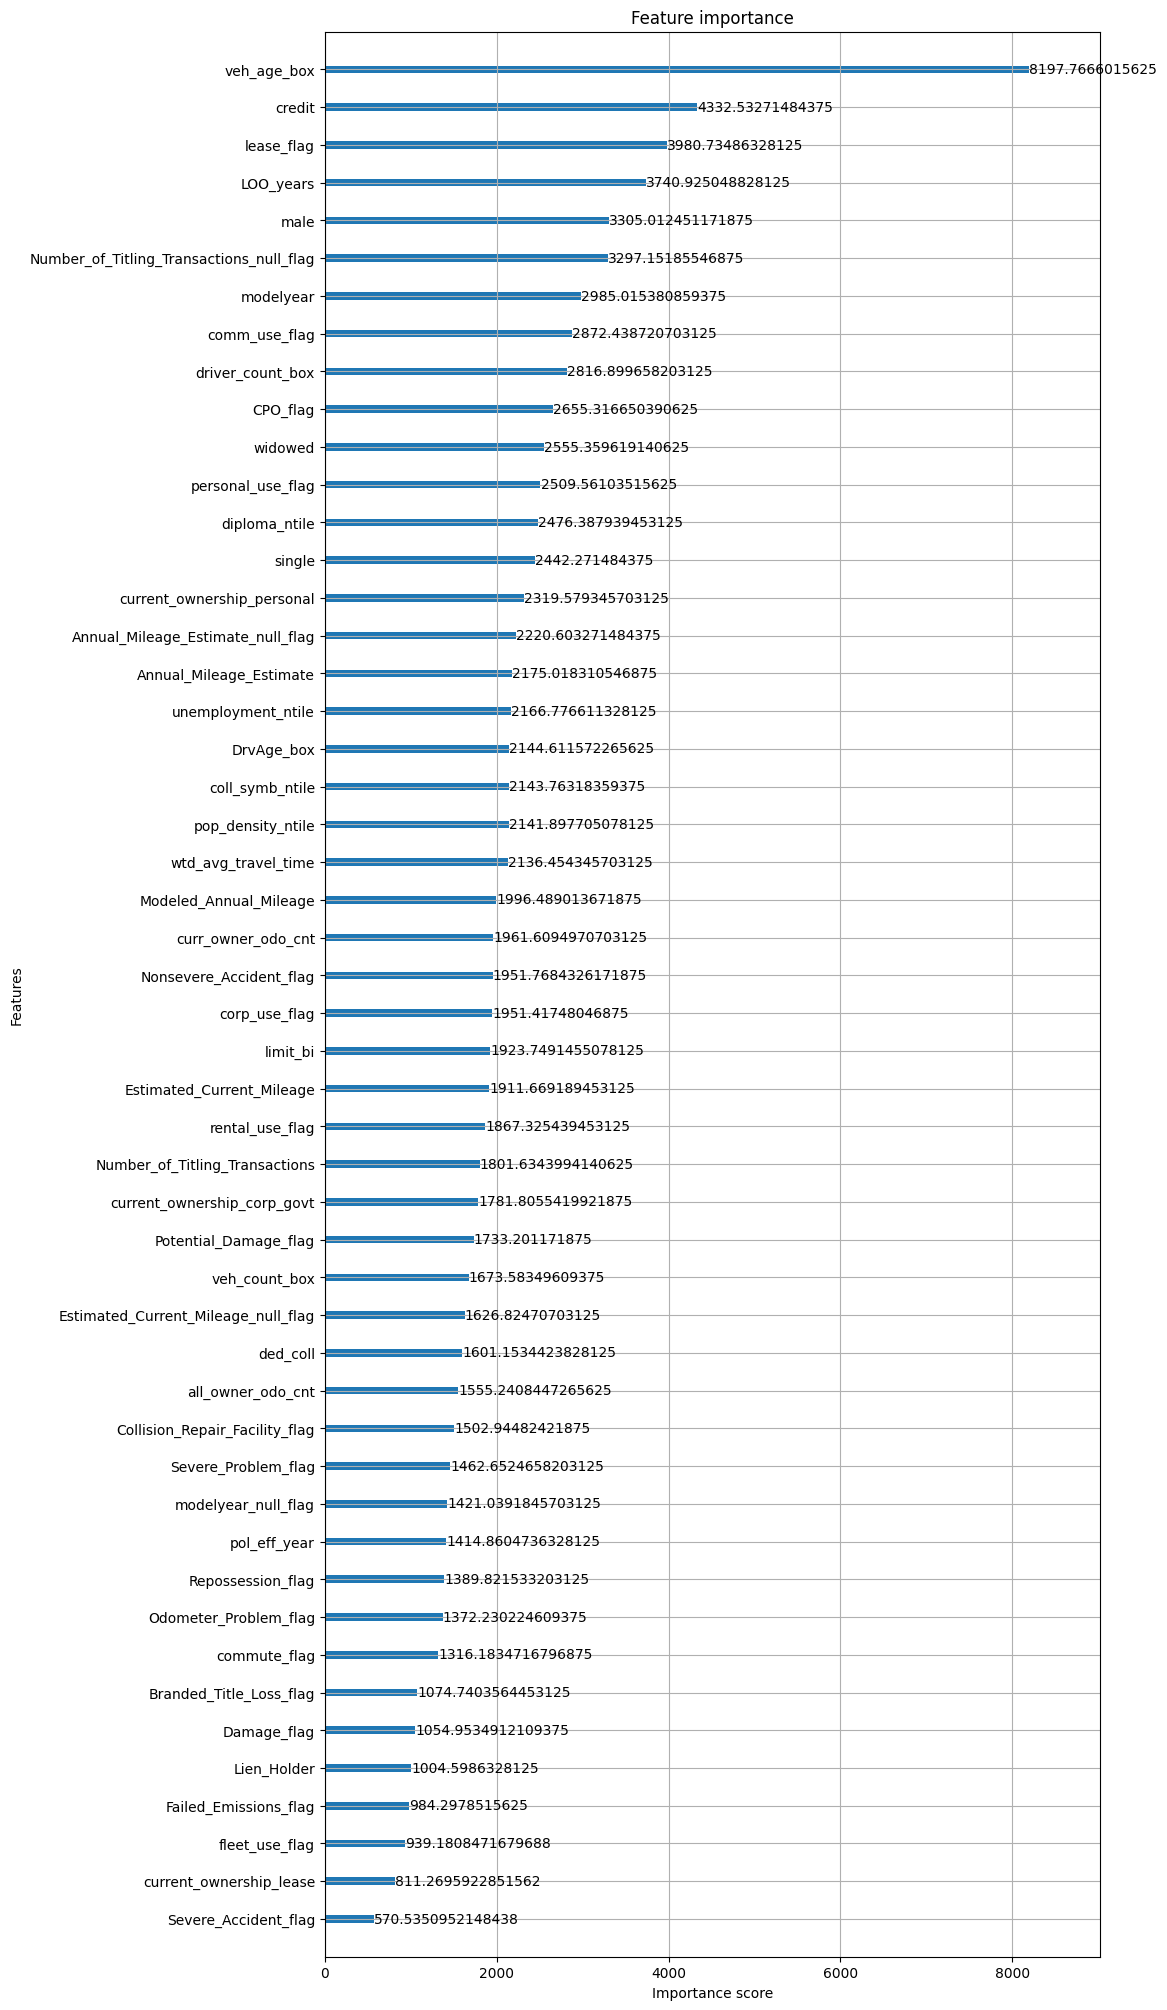

In [77]:
# plot_importance (first very basic importance display)

fig, ax = plt.subplots(figsize=(10, 25))
xgb.plot_importance(model_xgb, importance_type = 'gain', ax=ax)

# article about importance types: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

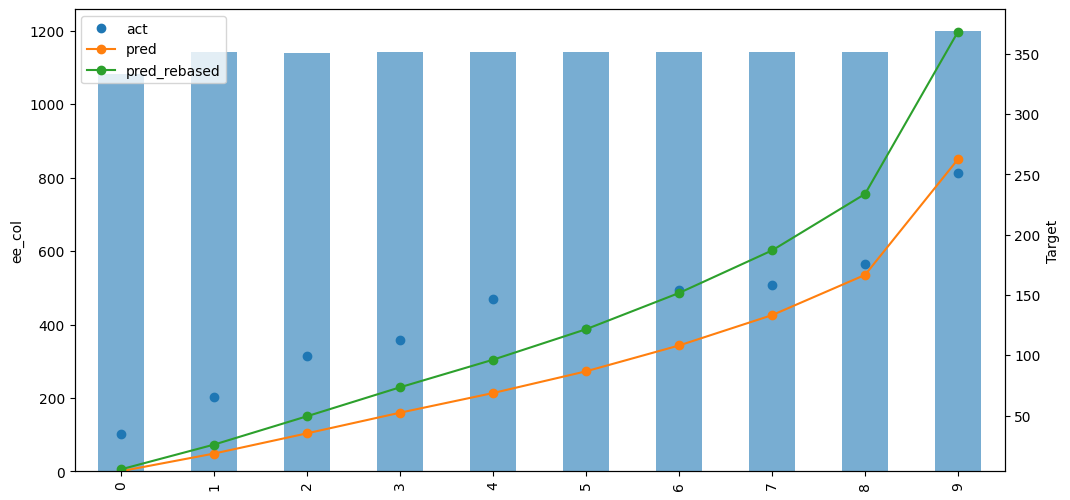

,decile,ee_col,act,pred,pred_rebased
0,1.00,"1,083.61",34.62,3.81,5.35
1,2.00,"1,141.34",65.64,18.44,25.87
2,3.00,"1,140.83",99.48,35.22,49.40
3,4.00,"1,141.07",112.48,52.34,73.42
4,5.00,"1,141.19",146.63,68.65,96.30
5,6.00,"1,140.90",121.49,86.67,121.59
6,7.00,"1,140.99",154.26,108.12,151.67
7,8.00,"1,141.25",158.28,133.29,186.98
8,9.00,"1,140.95",175.90,166.68,233.83
9,10.00,"1,198.31",251.53,262.72,368.55


In [90]:
# Review lift chart

lift_chart(out_test, 'incloss_col', 'pred_loss', 'ee_col', 10)

## GBM Function

In [82]:
# Functionize
cols_dict = {
    'target': 'pp_col',
    'weight': 'ee_col',
    'drop_cols':  [i for i in d_train if i.startswith(('ee_', 'ep_', 'cc_','incloss_','pp_','lr_','freq_','sev_'))]
}

params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.5,
  'learning_rate': .20,
  'verbosity': 1,
  'max_depth': 6,
  'num_round': 50,
  'type': 'pp' # pp, lr, freq, sev
}

def fit_xgb(train,test,cols_dict,params_dict):
    target = cols_dict['target']
    weight = cols_dict['weight']
    drop_cols = cols_dict['drop_cols']

    params = params_dict.copy()
    del params['num_round'], params['type']

    dtrain = xgb.DMatrix(train.drop(drop_cols, axis=1), label=train[target], weight=train[weight])
    dtest =  xgb.DMatrix(test.drop(drop_cols, axis=1),  label=test[target])

    model_xgb = xgb.train(params, dtrain, params_dict['num_round'])

    out_train = train.copy()
    out_train['pred'] = model_xgb.predict(dtrain)
    if params_dict['type'] == 'freq':
      out_train['pred_claims'] = out_train['pred'] * out_train[weight]
    else:
      out_train['pred_loss'] = out_train['pred'] * out_train[weight]

    out_test = test.copy()
    out_test['pred'] = model_xgb.predict(dtest)
    if params_dict['type'] == 'freq':
      out_test['pred_claims'] = out_test['pred'] * out_test[weight]
    else:
      out_test['pred_loss'] = out_test['pred'] * out_test[weight]

    return {'out_train': out_train,'out_test': out_test, 'model_xgb': model_xgb}

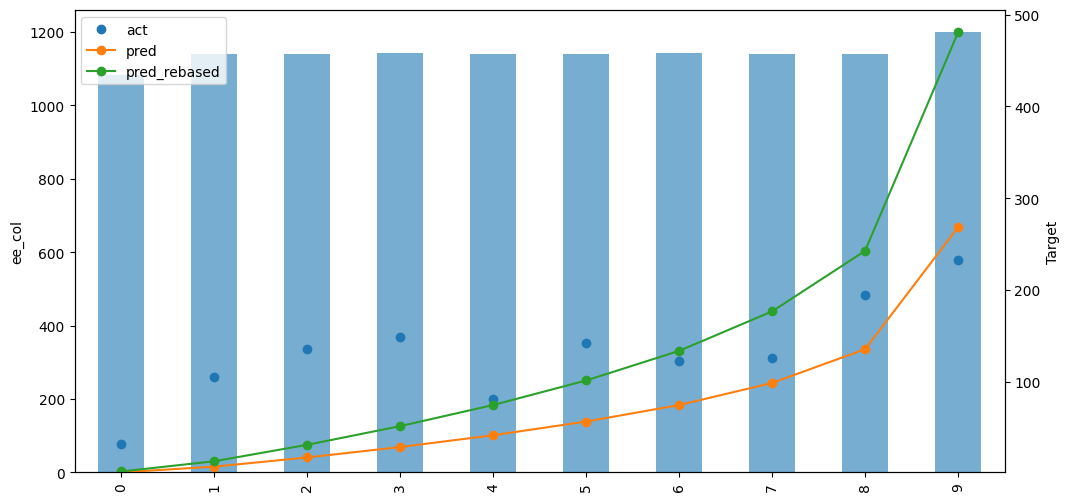

,decile,ee_col,act,pred,pred_rebased
0,1.00,"1,083.81",32.11,1.20,2.15
1,2.00,"1,140.98",105.40,7.40,13.26
2,3.00,"1,140.63",135.45,17.40,31.18
3,4.00,"1,141.44",148.88,28.76,51.53
4,5.00,"1,141.07",81.02,41.61,74.54
5,6.00,"1,140.87",141.65,56.54,101.30
6,7.00,"1,141.13",122.67,74.54,133.54
7,8.00,"1,141.06",126.02,98.56,176.57
8,9.00,"1,140.91",194.87,135.38,242.53
9,10.00,"1,198.55",233.03,268.23,480.53


In [91]:
model = fit_xgb(d_train,d_test,cols_dict,params_dict)

lift_chart(model['out_test'], 'incloss_col', 'pred_loss', 'ee_col', 10)

In [45]:
model['model_xgb']

## Hyperparameter tuning with cross validation

In [102]:
# 5 fold CV with gridsearch & optimization metrics

def model_metrics(input_data, act, pred, weight):
    test_data = input_data.copy()
    bins = 50

    test_data['decile'] = (round(test_data.sort_values(by = 'pred')[weight].cumsum()/test_data[weight].sum(),2)*bins).apply(np.floor)
    test_data['decile'] = np.where(test_data['decile'] + 1 > bins ,bins,test_data['decile'] + 1)
    x = test_data.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()

    del test_data

    x['target_act'] = x[act]/x[weight]
    x['target_pred'] = x[pred]/x[weight]
    x['target_pred_rebased'] = x['target_pred'] * (x[act].sum() / x[pred].sum())

    x['decile_error'] = abs(x['target_pred_rebased']/x['target_act'] - 1).replace(-np.inf, np.nan).replace(np.inf, np.nan).fillna(1)
    x['decile_error_sp'] = x['decile_error'] * x[weight]
    fit_quality = 1 - x['decile_error_sp'].sum()/x[weight].sum()
    fit_quality = np.maximum(fit_quality,0) # just in case we get negatives

    tot_target = x[act].sum()/x[weight].sum()
    x['pct_diff'] = abs(x['target_pred']/tot_target - 1)
    x['pct_diff_sp'] = x['pct_diff'] * x[weight]
    model_power = x['pct_diff_sp'].sum()/x[weight].sum()

    x.drop(columns = [act,pred], inplace = True)

    return {'model_power': model_power, 'fit_quality': fit_quality}

def tt_split_cv_5_folds(data,fold_num):
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])

    all_ints = [i for i in range(1, 101)]
    test_ints = [i for i in all_ints if i >= (fold_num-1) * 20 + 1 and i <= fold_num * 20]
    train_ints = [i for i in all_ints if i not in test_ints]

    d1_test = data.loc[data['rand'].isin(test_ints)].copy()
    d1_train = data.loc[data['rand'].isin(train_ints)].copy()

    del d1_test['rand'], d1_train['rand']

    return d1_train, d1_test

from IPython.display import display, clear_output

def cv_sub(d_train, cols_dict, hyperparams_dict, act, pred, weight):
    global result_final # try to avoid utilizing globals where you can, but this seems to make the most sense in this case since we are displaying a chart

    tweedie_p_list = hyperparams_dict['tweedie_p']
    learning_rate_lst = hyperparams_dict['learning_rate']
    max_depth_list = hyperparams_dict['max_depth']
    num_round_list = hyperparams_dict['num_round']

    result_temp = pd.DataFrame(columns = ['model_power','fit_quality','tweedie_p','learning_rate','max_depth','num_round'])
    for fold in range(1,6):
        d1_train, d1_test = tt_split_cv_5_folds(d_train,fold)
        for tweedie_p in tweedie_p_list:
            for learning_rate in learning_rate_lst:
                for max_depth in max_depth_list:
                    for num_round in num_round_list:
                        params_dict = {
                            'objective': 'reg:tweedie',
                            'tweedie_variance_power': tweedie_p,
                            'learning_rate': learning_rate,
                            'verbosity': 1,
                            'max_depth': max_depth,
                            'base_score': d_train[hyperparams_dict['base_score_num']].sum()/d_train[hyperparams_dict['base_score_denom']].sum(),
                            'num_round': num_round,
                            'type': hyperparams_dict['type']
                        }
                        model = fit_xgb(d1_train,d1_test,cols_dict,params_dict)

                        result = pd.DataFrame(model_metrics(model['out_test'], act, pred, weight), index = [0])

                        result['tweedie_p'] = params_dict['tweedie_variance_power']
                        result['learning_rate'] = params_dict['learning_rate']
                        result['max_depth'] = params_dict['max_depth']
                        result['num_round'] = params_dict['num_round']

                        result_temp = pd.concat([result_temp,result])

                        result_final = result_temp.groupby(['tweedie_p','learning_rate','max_depth','num_round']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

                        clear_output(wait=True)
                        fig = px.scatter(result_final, x='model_power', y='fit_quality', hover_data=['tweedie_p','learning_rate','max_depth','num_round'])

                        display(fig)
                        display(f"fold {fold} params = {tweedie_p}_{bmf}_{max_depth}_{num_round} complete")

    # fig.write_html(save_path) # Doesn't work in colab but leaving here for reference


def lift_cv_5_folds(data,cols_dict,params_dict,act,pred,bins = 10):
    x2 = pd.DataFrame()
    for fold in range(1,6):
        d1_train, d1_test = tt_split_cv_5_folds(d_train,fold)

        model = fit_xgb(d1_train,d1_test,cols_dict,params_dict)
        lift_data = model['out_test'].copy()

        weight = cols_dict['weight']
        lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight].cumsum()/lift_data[weight].sum(),2)*bins).apply(np.floor)
        lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)

        x = lift_data.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
        x2 = pd.concat([x2,x])
        print('fold ' + str(fold) + ' complete', end = '\r')

    # lift_chart(x2, act, pred, cols_dict['weight'], bins)

    dfg = x2.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    dfg['target_act'] = dfg[act]/dfg[weight]
    dfg['target_pred'] = dfg[pred]/dfg[weight]
    dfg['target_pred_rebased'] = dfg['target_pred'] * (dfg[act].sum() / dfg[pred].sum())
    dfg.drop(columns = [act,pred], inplace = True)

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_min = dfg[['target_act','target_pred','target_pred_rebased']].min(axis = 1).min() * 0.95
    y_max = dfg[['target_act','target_pred','target_pred_rebased']].max(axis = 1).max() * 1.05
    ax2.set_ylim(y_min,y_max)

    dfg[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['target_act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='target_act')
    dfg['target_pred'].plot(kind='line', ax=ax2, marker='o', legend='target_pred')
    dfg['target_pred_rebased'].plot(kind='line', ax=ax2, marker='o', legend='pred_rebased')

    ax.set_ylabel(weight)
    ax2.set_ylabel('Target')

    plt.show()
    display(dfg[(['decile',weight,'target_act','target_pred'])])

In [103]:
### Watch in action with just a small gridsearch

hyperparams_dict = {
    'tweedie_p': [1.5],
    'learning_rate': [.05,.10],
    'max_depth': [6],
    'num_round': [25,50],
    'type': 'pp',
    'base_score_num': 'incloss_col',
    'base_score_denom': 'ee_col'
}

cv_sub(d_train, cols_dict, hyperparams_dict, 'incloss_col', 'pred_loss', 'ee_col')

'fold 5 params = 1.5_0.1_6_50 complete'

In [104]:
result_final

,tweedie_p,learning_rate,max_depth,num_round,model_power,fit_quality
0,1.50,0.05,6,25,0.36,0.16
1,1.50,0.05,6,50,0.46,0.22
2,1.50,0.10,6,25,0.47,0.10
3,1.50,0.10,6,50,0.56,0.24


In [ ]:
# Next cell takes ~12 minutes to run

In [105]:
hyperparams_dict = {
    'tweedie_p': [1.4,1.5,1.6],
    'learning_rate': [.05,.10,.20],
    'max_depth': [6,8,10],
    'num_round': [50,75,100],
    'type': 'pp',
    'base_score_num': 'incloss_col',
    'base_score_denom': 'ee_col'
}

cv_sub(d_train, cols_dict, hyperparams_dict, 'incloss_col', 'pred_loss', 'ee_col')

'fold 5 params = 1.6_0.1_10_100 complete'

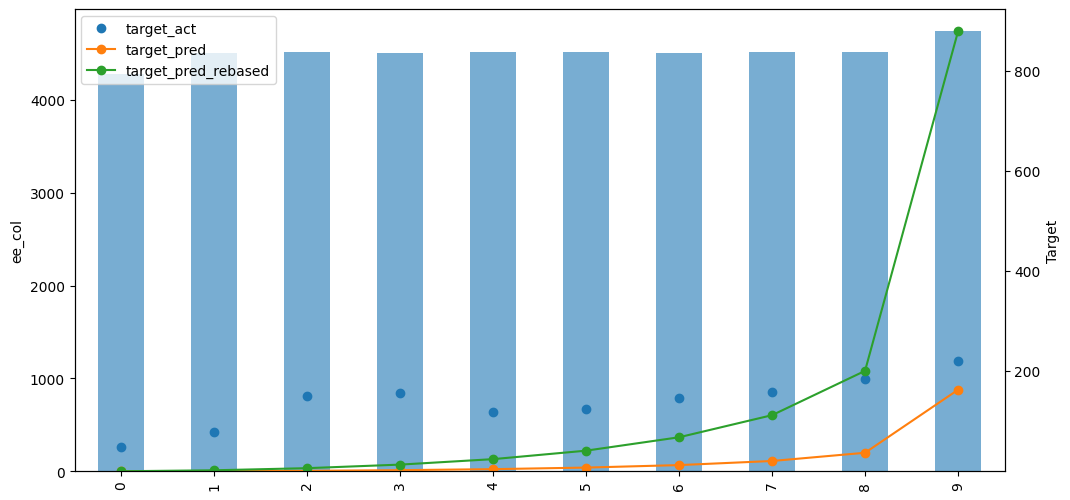

,decile,ee_col,target_act,target_pred
0,1.00,"4,282.12",49.56,0.07
1,2.00,"4,507.50",78.80,0.43
2,3.00,"4,510.02",150.19,1.21
3,4.00,"4,507.61",156.48,2.53
4,5.00,"4,509.02",118.15,4.56
5,6.00,"4,508.80",124.05,7.70
6,7.00,"4,508.49",146.09,12.67
7,8.00,"4,509.28",157.70,20.86
8,9.00,"4,509.06",183.84,37.29
9,10.00,"4,735.64",220.08,163.14


In [107]:
# Review some top performers to narrow down search

### Most powerful
params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .20,
  'verbosity': 1,
  'max_depth': 8,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 75,
  'type': 'pp'
}

lift_cv_5_folds(d_train,cols_dict,params_dict,'incloss_col', 'pred_loss',bins = 10)

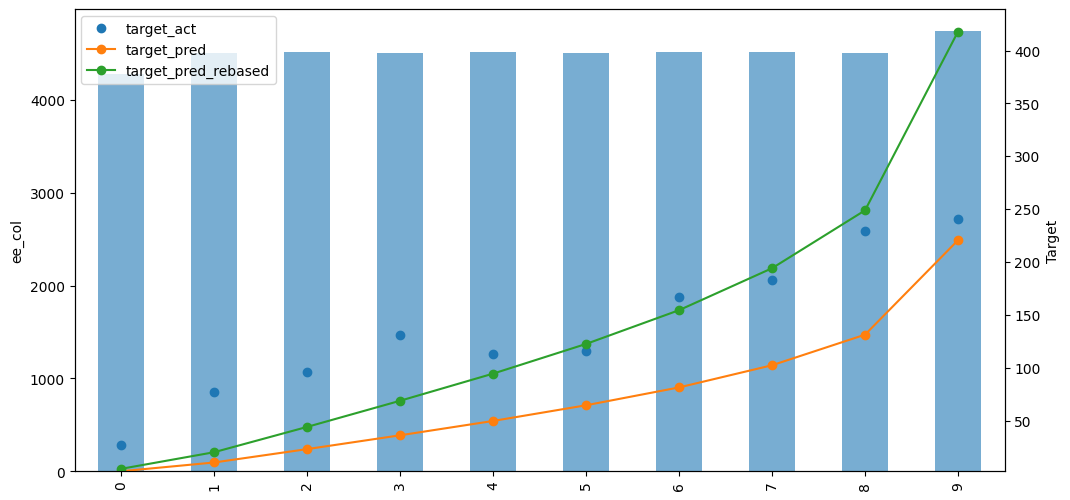

,decile,ee_col,target_act,target_pred
0,1.00,"4,282.50",27.67,2.57
1,2.00,"4,507.73",77.64,10.86
2,3.00,"4,509.79",95.89,23.49
3,4.00,"4,507.45",131.42,36.54
4,5.00,"4,509.99",113.08,50.09
5,6.00,"4,507.69",116.54,64.91
6,7.00,"4,509.07",166.72,81.77
7,8.00,"4,509.08",183.41,102.71
8,9.00,"4,508.22",229.86,131.60
9,10.00,"4,736.01",240.61,220.86


In [108]:
### Best fit quality
params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .05,
  'verbosity': 1,
  'max_depth': 8,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 75,
  'type': 'pp'
}

lift_cv_5_folds(d_train,cols_dict,params_dict,'incloss_col', 'pred_loss',bins = 10)

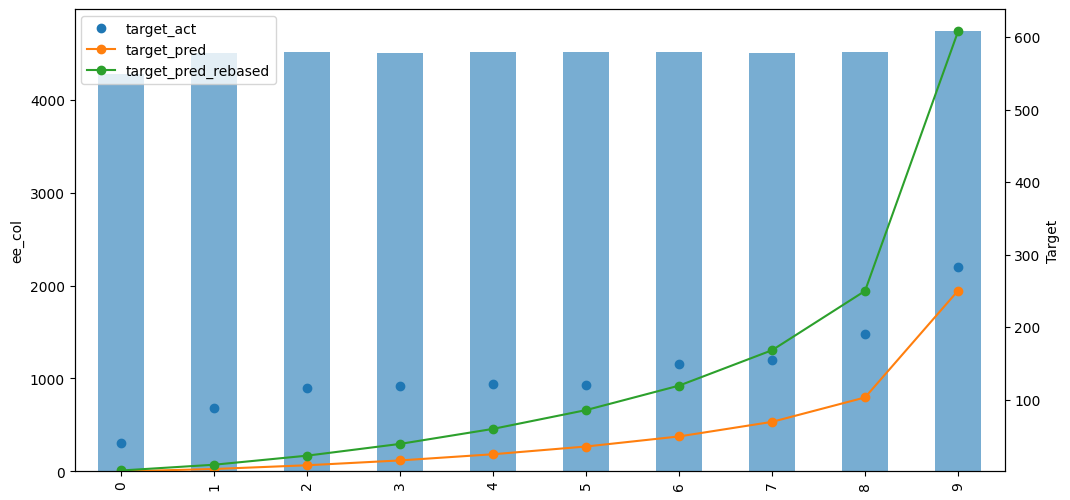

,decile,ee_col,target_act,target_pred
0,1.00,"4,281.98",40.49,0.84
1,2.00,"4,507.69",88.11,4.12
2,3.00,"4,510.00",115.44,9.27
3,4.00,"4,507.80",119.16,15.95
4,5.00,"4,508.43",121.30,24.48
5,6.00,"4,509.46",119.80,35.15
6,7.00,"4,509.44",149.68,49.05
7,8.00,"4,508.05",154.63,69.16
8,9.00,"4,509.52",190.34,102.85
9,10.00,"4,735.18",282.42,250.23


In [109]:
### Blend
params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .20,
  'verbosity': 1,
  'max_depth': 6,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 75,
  'type': 'pp'
}

lift_cv_5_folds(d_train,cols_dict,params_dict,'incloss_col', 'pred_loss',bins = 10)

In [110]:
result_final.groupby(['tweedie_p']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

,tweedie_p,model_power,fit_quality
0,1.40,0.74,0.10
1,1.50,0.76,0.08
2,1.60,0.77,0.07


In [111]:
result_final.groupby(['learning_rate']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

,learning_rate,model_power,fit_quality
0,0.05,0.63,0.14
1,0.10,0.76,0.08
2,0.20,0.89,0.03


In [112]:
result_final.groupby(['max_depth']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

,max_depth,model_power,fit_quality
0,6,0.63,0.14
1,8,0.77,0.08
2,10,0.87,0.03


In [113]:
result_final.groupby(['num_round']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

,num_round,model_power,fit_quality
0,50,0.70,0.11
1,75,0.76,0.09
2,100,0.81,0.05


In [ ]:
# Iterations

In [ ]:
# Next cell takes ~5 minutes to run

In [114]:
### Looks like we need to go for more conservative parameters and stick with tweedie_p = 1.4 for better fit quality

hyperparams_dict = {
    'tweedie_p': [1.4],
    'learning_rate': [.025,.05,.075],
    'max_depth': [4,6],
    'num_round': [25,35,40,45,50],
    'type': 'pp',
    'base_score_num': 'incloss_col',
    'base_score_denom': 'ee_col'
}

cv_sub(d_train, cols_dict, hyperparams_dict, 'incloss_col', 'pred_loss', 'ee_col')

'fold 5 params = 1.4_0.1_6_50 complete'

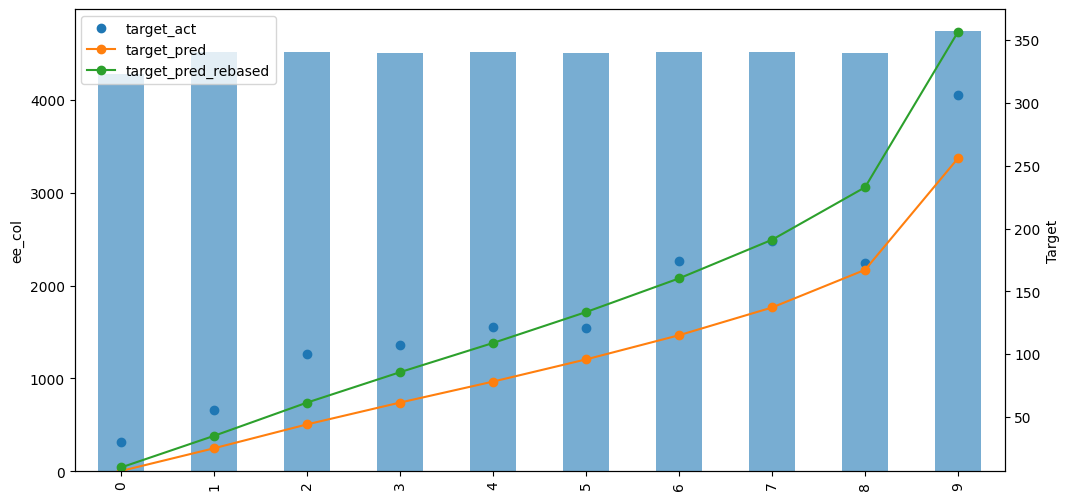

,decile,ee_col,target_act,target_pred
0,1.00,"4,281.61",29.94,7.09
1,2.00,"4,509.22",55.61,25.17
2,3.00,"4,508.87",100.35,44.18
3,4.00,"4,507.94",107.05,61.55
4,5.00,"4,508.95",122.02,78.25
5,6.00,"4,508.45",121.16,95.92
6,7.00,"4,509.45",174.16,115.16
7,8.00,"4,508.89",190.31,137.24
8,9.00,"4,508.28",172.70,167.24
9,10.00,"4,735.86",306.32,256.12


In [115]:
# Option 1

params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .075,
  'verbosity': 1,
  'max_depth': 6,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 50,
  'type': 'pp'
}

lift_cv_5_folds(d_train,cols_dict,params_dict,'incloss_col', 'pred_loss',bins = 10)

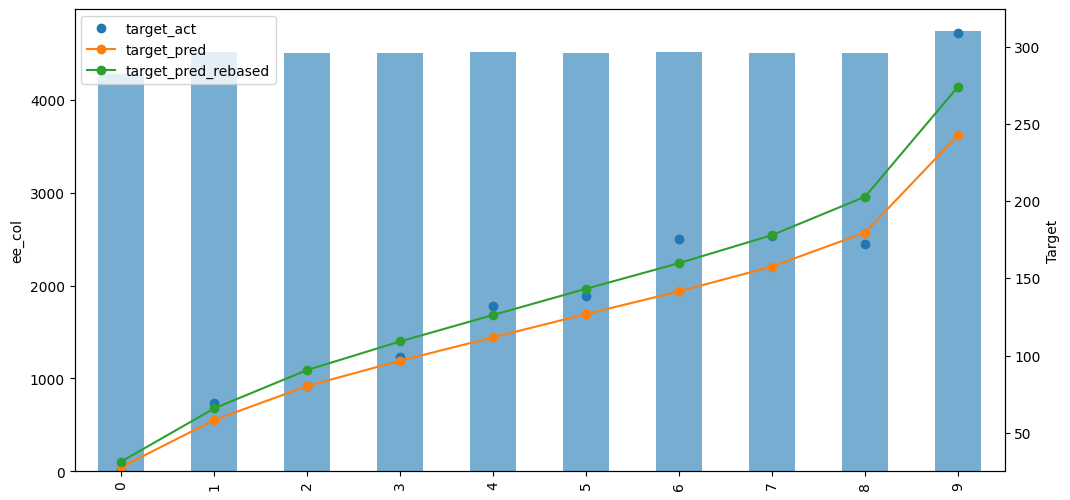

,decile,ee_col,target_act,target_pred
0,1.00,"4,281.13",26.42,27.82
1,2.00,"4,508.95",69.62,58.29
2,3.00,"4,508.75",80.39,80.32
3,4.00,"4,508.60",99.23,96.70
4,5.00,"4,509.43",132.28,111.85
5,6.00,"4,508.46",138.31,126.88
6,7.00,"4,509.36",175.23,141.58
7,8.00,"4,508.30",177.28,157.65
8,9.00,"4,508.60",171.99,179.63
9,10.00,"4,735.95",308.59,242.68


In [116]:
# Option 2

params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .05,
  'verbosity': 1,
  'max_depth': 4,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 40,
  'type': 'pp'
}

lift_cv_5_folds(d_train,cols_dict,params_dict,'incloss_col', 'pred_loss',bins = 10)

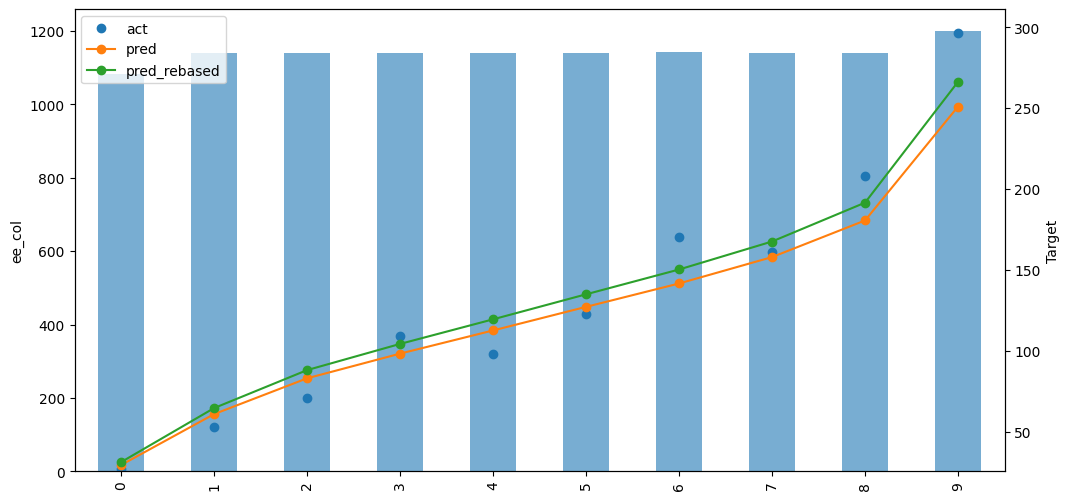

,decile,ee_col,act,pred,pred_rebased
0,1.00,"1,083.95",26.90,29.49,31.28
1,2.00,"1,140.33",53.02,60.97,64.68
2,3.00,"1,141.35",71.24,83.10,88.17
3,4.00,"1,141.25",109.12,98.37,104.36
4,5.00,"1,140.94",97.84,112.70,119.57
5,6.00,"1,140.65",122.99,127.28,135.04
6,7.00,"1,141.69",170.73,141.73,150.38
7,8.00,"1,140.26",161.39,158.05,167.69
8,9.00,"1,140.94",207.98,180.68,191.70
9,10.00,"1,199.09",296.36,251.13,266.44


In [118]:
# Review lift chart on test data to make final selection

# Go with option 2
d_train, d_test = tt_split(df,.80)

params_dict = {
  'objective': 'reg:tweedie',
  'tweedie_variance_power': 1.4,
  'learning_rate': .05,
  'verbosity': 1,
  'max_depth': 4,
  'base_score': d_train['incloss_col'].sum()/d_train['ee_col'].sum(),
  'num_round': 40,
  'type': 'pp'
}

model = fit_xgb(d_train,d_test,cols_dict,params_dict)

lift_chart(model['out_test'], 'incloss_col', 'pred_loss', 'ee_col', 10)

In [119]:
model_xgb = model['model_xgb'] # this is our "final model"

## SHAP to evaluate model behavior

In [ ]:
# Next cell takes ~25 minutes to run

PermutationExplainer explainer: 16028it [31:40,  8.42it/s]


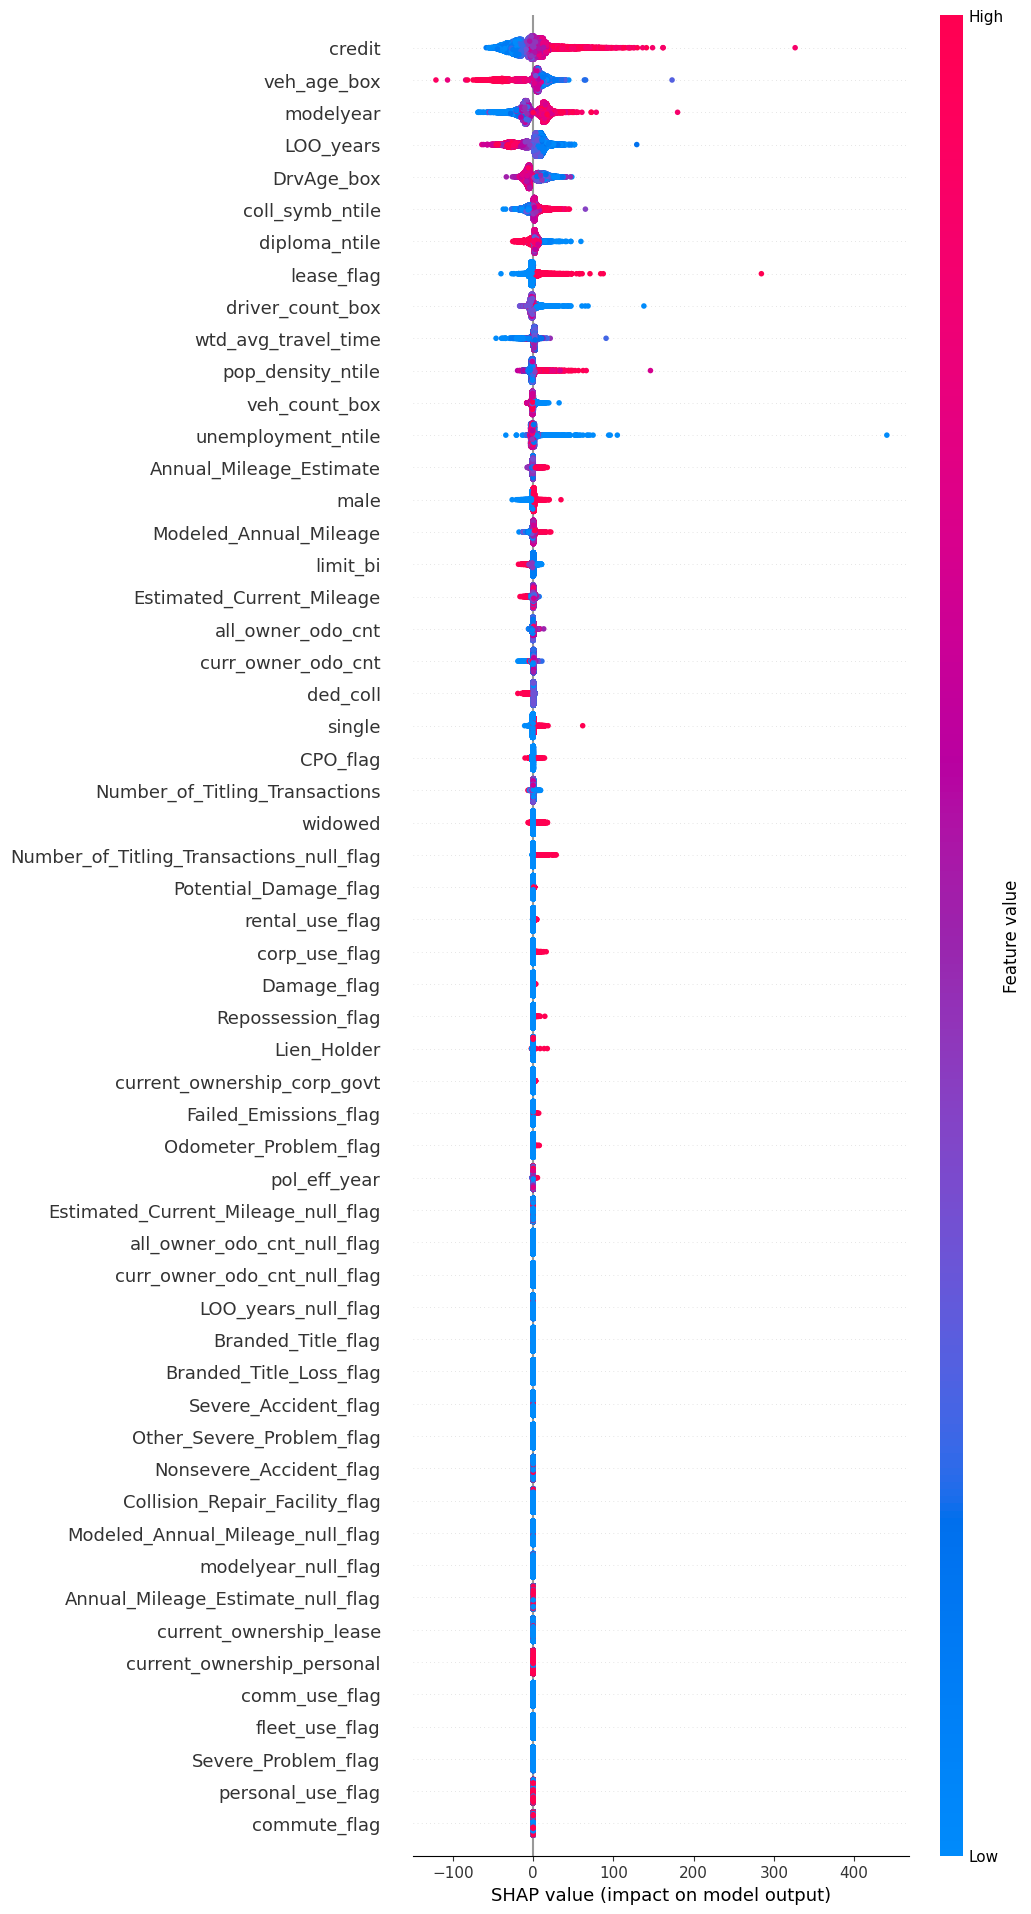

In [120]:
# SHAP
def xgb_model_predict(data):
    dmatrix_data = xgb.DMatrix(data, feature_names=model_xgb.feature_names)
    return model_xgb.predict(dmatrix_data)

train_sample = d_train[(model_xgb.feature_names)].sample(n = int(d_train.shape[0]*.20)) #20% sample to save time

background = shap.maskers.Independent(train_sample)
explainer = shap.Explainer(xgb_model_predict, background, approximate = True)
shap_values = explainer(train_sample)
shap.plots.beeswarm(shap_values, max_display = 999)

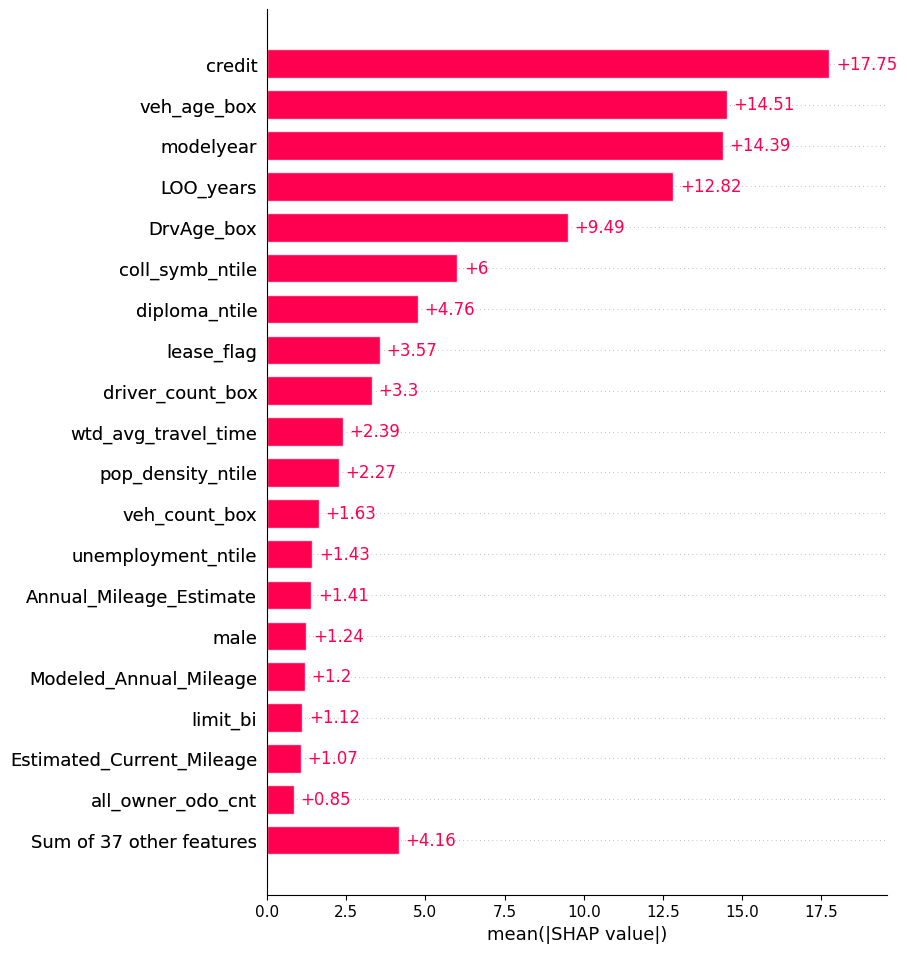

In [121]:
# SHAP bar
shap.plots.bar(shap_values, max_display=20)

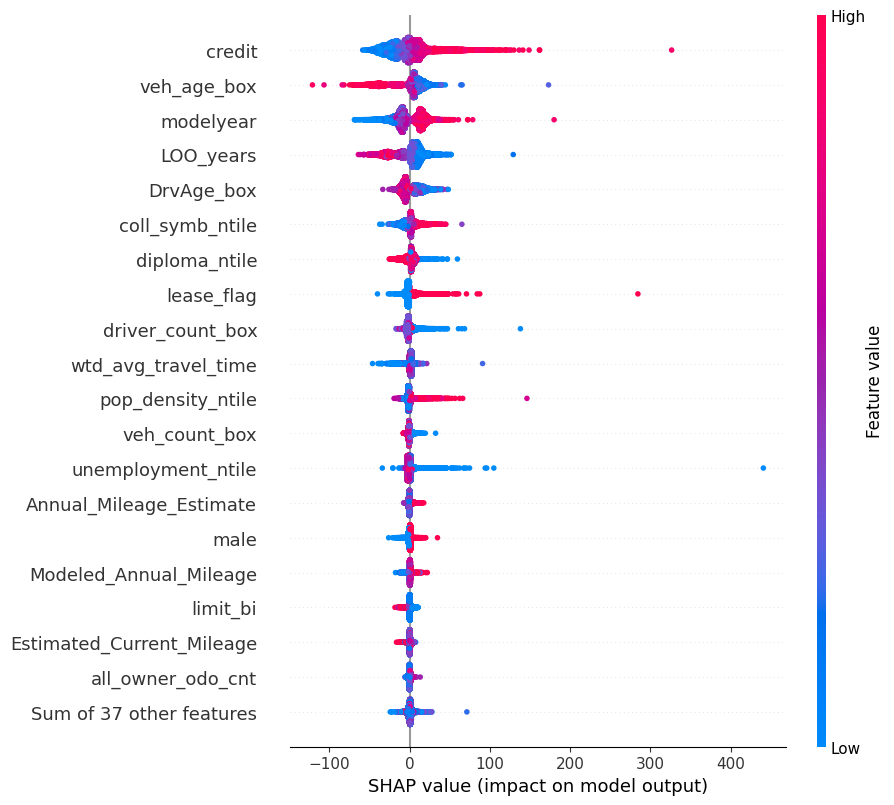

In [122]:
# SHAP beeswarm
shap.plots.beeswarm(shap_values, max_display = 20)

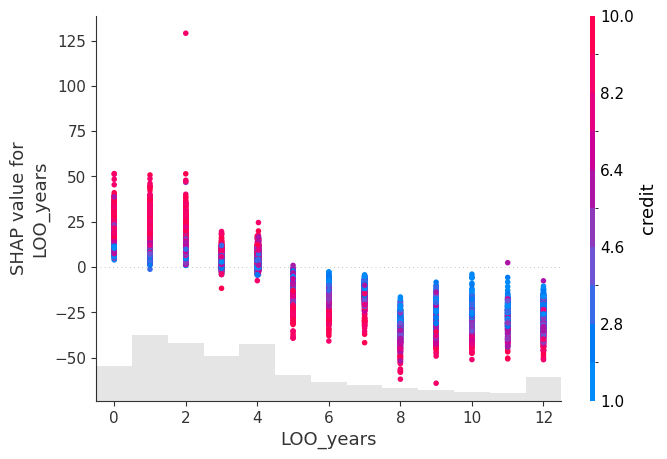

In [123]:
# SHAP Scatter (codependence)

def shap_scatter_p1_p99(data,var,color_by):
    global a, b
    a = data.groupby([var]).agg({'ee_col': 'sum'}).reset_index()
    a['cumsum'] = a['ee_col'].cumsum()
    a['ntile'] = round(a['cumsum']/a[len(a)-1:len(a)]['cumsum'].values,3)
    xmax = a.loc[a['ntile'] >= .99][0:1][var].values

    if a.loc[a['ntile'] <= .01][::][var].shape[0] == 0:
        xmin = a[0:1][var].values
    else:
        b = a.loc[a['ntile'] <= .01][::][var].copy()
        xmin = b[len(b)-1:len(b)].values

    x = shap_values[:, var]
    shap.plots.scatter(x
                       , color=shap_values[:,color_by]
                       , xmin=xmin
                       , xmax=xmax
                      )

shap_scatter_p1_p99(d_train,'LOO_years','credit')

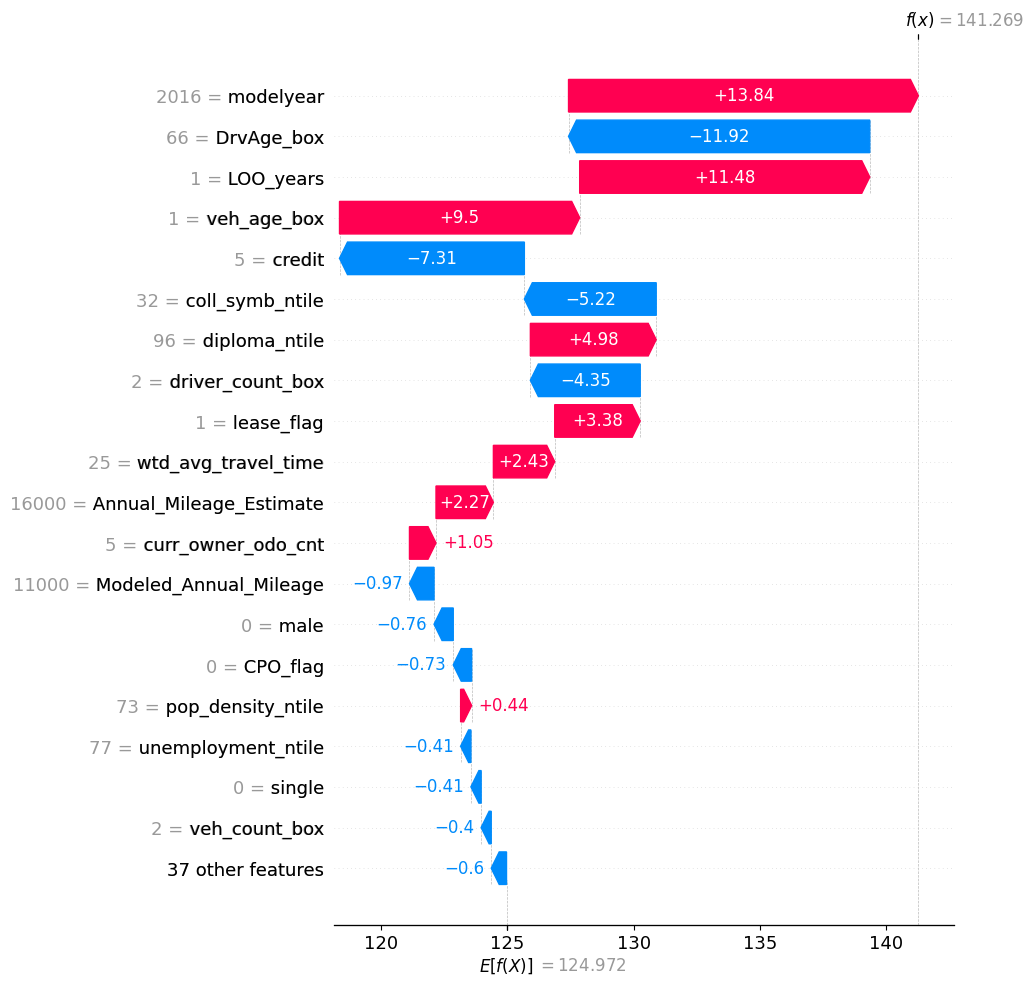

In [124]:
# SHAP Waterfall (individual)
shap.plots.waterfall(shap_values[0], max_display = 20)

In [125]:
model_xgb.trees_to_dataframe() # This is here for reference

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,modelyear,"2,012.00",0-1,0-2,0-2,"125,938.14","872,023.25",NaN
1,0,1,0-1,veh_age_box,14.00,0-3,0-4,0-4,"46,070.50","421,402.19",NaN
2,0,2,0-2,credit,9.00,0-5,0-6,0-6,"73,631.22","450,621.06",NaN
3,0,3,0-3,credit,4.00,0-7,0-8,0-8,"26,652.94","334,164.00",NaN
4,0,4,0-4,LOO_years,1.00,0-9,0-10,0-10,"7,476.80","87,238.20",NaN
...,...,...,...,...,...,...,...,...,...,...,...
1221,39,26,39-26,Leaf,NaN,NaN,NaN,NaN,0.05,"2,938.07",NaN
1222,39,27,39-27,Leaf,NaN,NaN,NaN,NaN,-0.07,"3,372.51",NaN
1223,39,28,39-28,Leaf,NaN,NaN,NaN,NaN,0.03,362.61,NaN
1224,39,29,39-29,Leaf,NaN,NaN,NaN,NaN,0.05,"8,720.03",NaN


### Group Discussion
#### Discuss the SHAP Beeswarm plot.  Are the results reasonable?
#### Call out any interactions that are worth discussion using the shap scatter plot

## Advice for explainable GBM in insurance applications
### Clip and bucket your feature levels until you have logical relationships that are monotonic in your one ways
### Set the same monotonicity for your model
### If the SHAP shows the model misbehaving, change your bucketing again